In [1]:
# magic reload
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
from datasets import load_dataset

### Accuracy of QA expert

In [2]:
qa_df = prepare_df(types=['qa'])
filter = {'config_model_name_qa': 'deepseek/deepseek-v3.1-terminus', 'config_dataset_name_qa': 'Idavidrein/gpqa', 'config_dataset_subset_qa': 'gpqa_diamond', 'config_dataset_split_qa': 'train'}
qa_df_deepseek_31_terminus = qa_df[qa_df.apply(lambda row: all(row[col] == val for col, val in filter.items()), axis=1)]

In [3]:
print(qa_df_deepseek_31_terminus['is_correct_qa'].mean().round(2))

0.71


### Analyze Debate

In [4]:
check_df = load_all_records_into_df('debate_checks')
check_df = check_df[check_df['run_id_debate_checks'] == 'z1qae3w']
check_df['has_leak_debate_checks'].value_counts()

has_leak_debate_checks
False    91
True     63
Name: count, dtype: int64

### Analysis Setup

In [10]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

### 2 vs 4 choice

In [ ]:
# verdict_ids_2_choice_gpqa =  None
# verdict_ids_4_choice_gpqa =  ['sobqzs5', 'patmaoz', 'k3g3ru8', '6ar2b9m', 'dxs53tg', 'svgtpf8', 'kzyf7dh', 'y0jfaa0', 'gkl2mac', 'ylbtlv5']
# verdict_ids_4_choice_gpqa = ['sobqzs5', 'patmaoz', 'k3g3ru8', '6ar2b9m', 'dxs53tg', '7xaab5m', 'kzyf7dh', 'y0jfaa0', 'gkl2mac', 'ylbtlv5']


verdict_ids_4_choice_gpqa_deepseek = ['sobqzs5', 'patmaoz', 'k3g3ru8', '6ar2b9m', 'dxs53tg', '7xaab5m', 'xpj21b8', 'y0jfaa0', 'gkl2mac', 'ylbtlv5']
verdict_ids_4_choice_gpqa_other = ['twcd0i7', 'w3fzren', '848txz6', '4p6z0f2', 'jh9uni7', 'ijrv907', '7uc0b4u', '6xfi9ae', '29d3u8s', 'e6w8a2j', 'a8vpm61', 'cdy781w', 'vph6suh', 'vhu3gj6', 'jrjvopc', 'ufo1i3x', 'vhx11d7']

verdict_ids = verdict_ids_4_choice_gpqa_deepseek + verdict_ids_4_choice_gpqa_other

verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids)]
# verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa + verdict_ids_4_choice_gpqa)] # TODO

# optionally, only keep records that don't have a leak
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

# optionally, only keep recordsthat appear in both 2 and 4 choice
# verdicts_df = verdicts_df[verdicts_df.groupby(['config_judge_model_verdicts', 'question_idx_debates']).transform('size')==2].reset_index(drop=True)
# optionally, only keep records (questions) that appear in every run (or adjust to >= tot_runs - x to make more lenient)
# tot_runs = len(verdict_ids + verdict_ids) 
# verdicts_df = verdicts_df[verdicts_df.groupby(['question_idx_debates']).transform('size') >= tot_runs-5].reset_index(drop=True)  # 

# df_2_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa)]
df_4_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids)]

# acc_2_choice_gpqa = aggregate_by_fields(df_2_choice_gpqa, ['config_judge_model_verdicts'])
acc_4_choice_gpqa = aggregate_by_fields(df_4_choice_gpqa, ['config_judge_model_verdicts'])

print(df_4_choice_gpqa.shape)
# print(df_2_choice_gpqa.shape, df_4_choice_gpqa.shape)

(3410, 87)


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


In [17]:
verdicts_df['is_correct_qa_debater'].value_counts(normalize=True)

is_correct_qa_debater
True     0.732845
False    0.267155
Name: proportion, dtype: float64

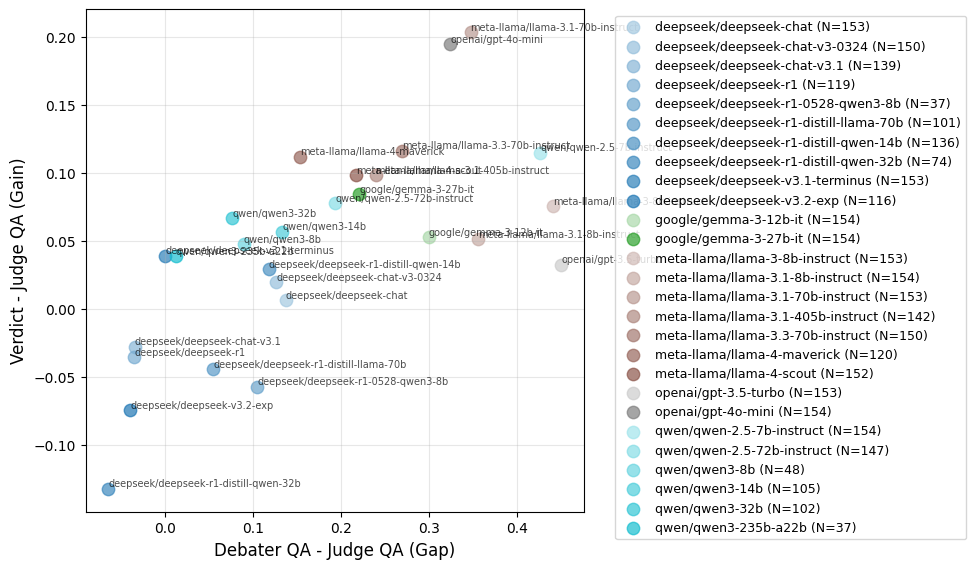

In [18]:
results_df = acc_4_choice_gpqa
# results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='gap') # or over=judge_qa

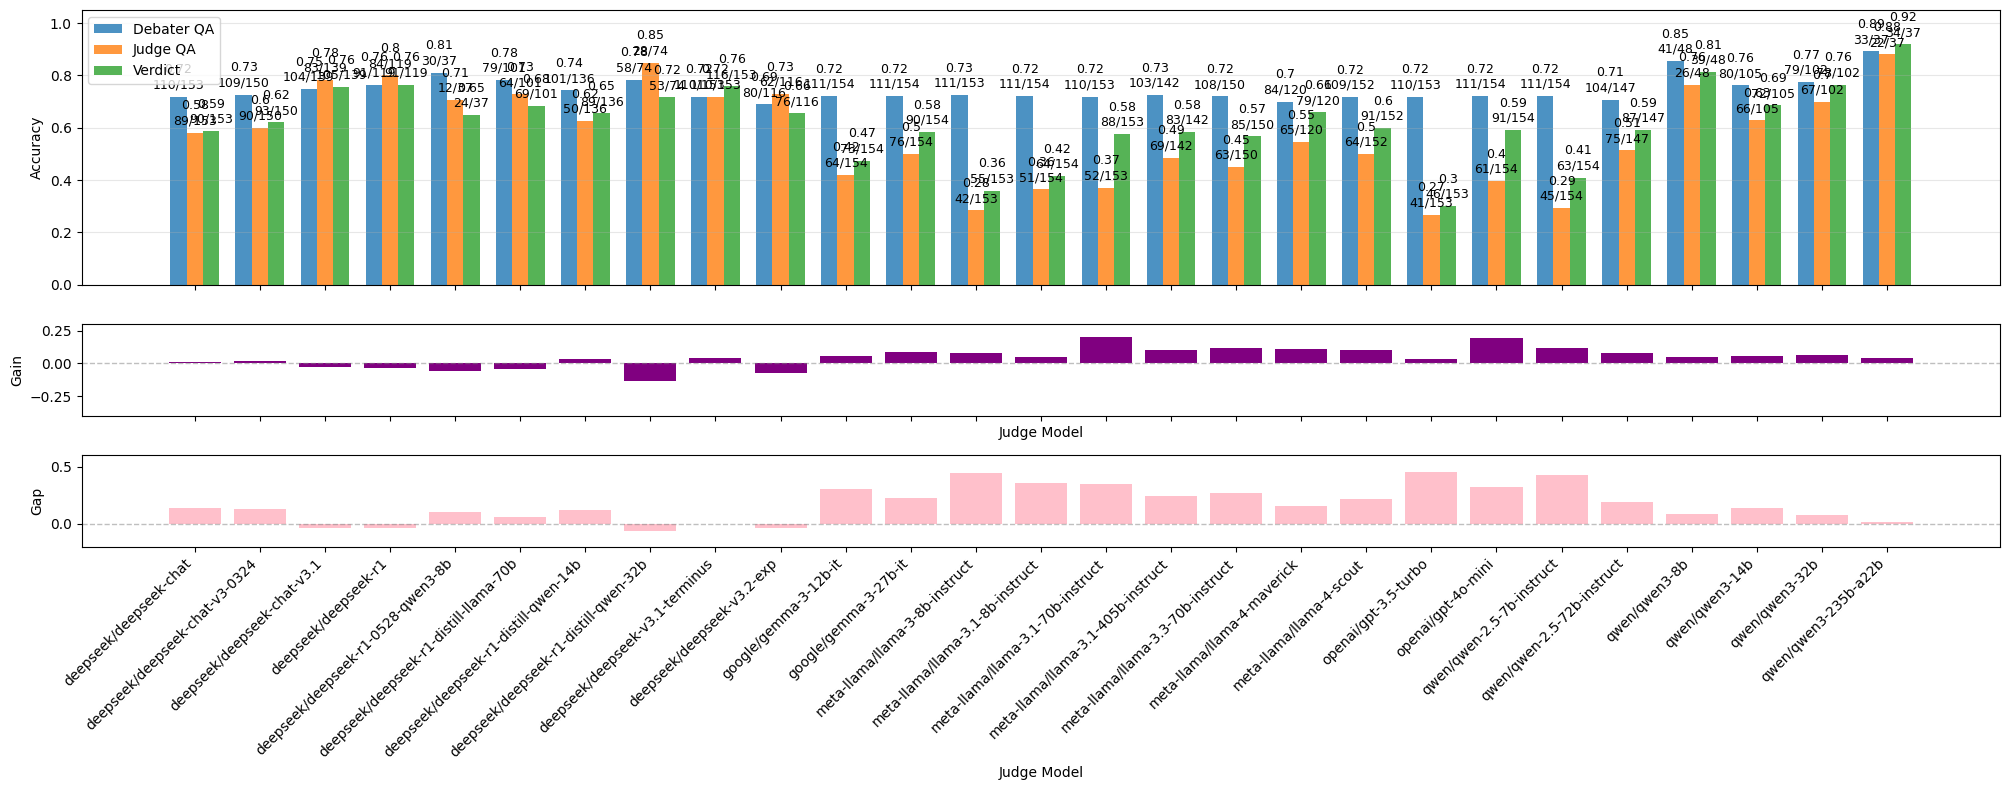

In [19]:
plt, ax_gain, ax_gap = plot_results_by_name(acc_4_choice_gpqa)
ax_gain.set_ylim([-.4, .3])
ax_gap.set_ylim([-.2, .6])
plt.show()